# Compare the power spectral density of different autoregressive models of $a_0$

In [2]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from datetime import datetime
import h5py

import arviz as az

from soda.utils.timeseries import timeseries, skill, rmse
from soda.utils.uspectra import uspectra, getTideFreq
from soda.utils.othertime import SecondsSince, TimeVector
from soda.utils.mysignal import power_spectra

from scipy import signal

from tqdm import tqdm

import matplotlib as mpl

In [3]:
%matplotlib notebook

In [4]:
mpl.rcParams['font.size'] = 14
mpl.rcParams['axes.labelsize'] = 'large'

In [8]:
na = 0
arn = 1

a0ncfile = '../inputs/a0_samples_harmonicfit_M2S2N2K1O1_na{}_AR{}_12month.nc'# .format(na, arn)


In [12]:
# Load the observation data
ds_obs = xr.open_dataset(a0ncfile.format(0,1), group='observed_data')


<xarray.Dataset>
Dimensions:  (chain: 1, draw: 500, time: 8785)
Coordinates:
  * chain    (chain) int64 1
  * draw     (draw) int64 0 1 2 3 4 5 6 7 8 ... 492 493 494 495 496 497 498 499
  * time     (time) datetime64[ns] 2016-05-01 2016-05-01T01:00:00 ... 2017-05-02
Data variables:
    a0       (chain, draw, time) float64 ...
Attributes:
    created_at:                 2020-11-26T06:04:52.516484
    arviz_version:              0.10.0
    inference_library:          pymc3
    inference_library_version:  3.9.3

In [51]:
def calc_psd_stats(ds, tsec):
    ns = ds_a0.dims['draw']
    nf = tsec.shape[0]//2

    Spred = np.zeros((ns,nf))
    for ii in tqdm(range(ns)):
        fpred, Spred[ii,:], dfpred = power_spectra(tsec, ds['a0'][0, ii,:].values, K=1 )

    # Compute the stats on the spectra
    Smid = np.median(Spred, axis=0)/scale
    Shigh = np.percentile(Spred, 66, axis=0)/scale
    Slow = np.percentile(Spred, 33, axis=0)/scale
    
    return Smid, Slow, Shigh, fpred

In [53]:
# Interpolate onto a regular time grid
timeinterp = ds_a0['time'].values
A_n_1h_i = ds_obs['X_obs'].interp({'time':timeinterp})
#A_n_1h_i = A_n_1h.interp({'time':timeinterp})


tsec = timeinterp.view(int)*1e-9

f, S, df = power_spectra(tsec, A_n_1h_i.values, K=1 )

#f, S3, df = power_spectra(tsec, A_n_1h_i.values, K=3)

#dt=60
scale =86400/(2*np.pi) 
fcpd = f*scale

In [58]:
# Load the observation data

ds_ar1 = xr.open_dataset(a0ncfile.format(0,1), group='predictions')
Smid_ar1, Slow_ar1, Shigh_ar1, fpred = calc_psd_stats(ds_ar1, tsec)

ds_ar2 = xr.open_dataset(a0ncfile.format(0,2), group='predictions')
Smid_ar2, Slow_ar2, Shigh_ar2, fpred = calc_psd_stats(ds_ar2, tsec)

ds_ar3 = xr.open_dataset(a0ncfile.format(0,3), group='predictions')
Smid_ar3, Slow_ar3, Shigh_ar3, fpred = calc_psd_stats(ds_ar3, tsec)

ds_ar4 = xr.open_dataset(a0ncfile.format(0,4), group='predictions')
Smid_ar4, Slow_ar4, Shigh_ar4, fpred = calc_psd_stats(ds_ar4, tsec)

ds_ar5 = xr.open_dataset(a0ncfile.format(0,5), group='predictions')
Smid_ar5, Slow_ar5, Shigh_ar5, fpred = calc_psd_stats(ds_ar5, tsec)

100%|██████████| 500/500 [00:37<00:00, 13.45it/s]


<IPython.core.display.Javascript object>


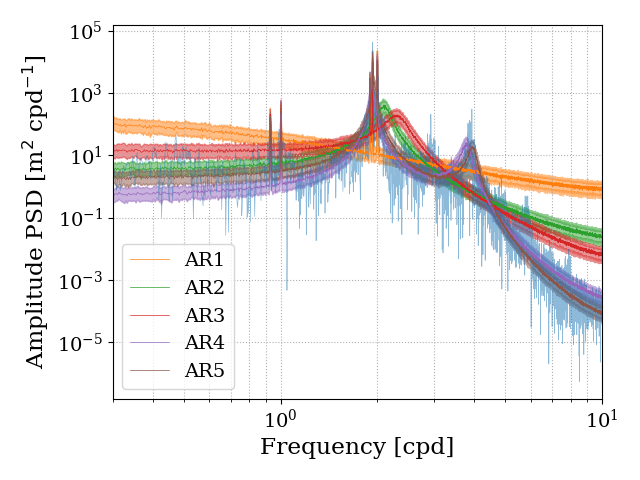

In [65]:
plt.figure()

plt.loglog(fcpd,S/scale, lw=0.5, alpha=0.5)

p1, = plt.loglog(fcpd,Smid_ar1, lw=0.5, alpha=1)
plt.fill_between(fcpd, Slow_ar1, Shigh_ar1, color= p1.get_color(), alpha=0.5)

p2, = plt.loglog(fcpd,Smid_ar2, lw=0.5, alpha=1)
plt.fill_between(fcpd, Slow_ar2, Shigh_ar2, color= p2.get_color(), alpha=0.5)

p3, = plt.loglog(fcpd,Smid_ar3, lw=0.5, alpha=1)
plt.fill_between(fcpd, Slow_ar3, Shigh_ar3, color= p3.get_color(), alpha=0.5)

p4, = plt.loglog(fcpd,Smid_ar4, lw=0.5, alpha=1)
plt.fill_between(fcpd, Slow_ar4, Shigh_ar4, color= p4.get_color(), alpha=0.5)

p5, = plt.loglog(fcpd,Smid_ar5, lw=0.5, alpha=1)
plt.fill_between(fcpd, Slow_ar5, Shigh_ar5, color= p5.get_color(), alpha=0.5)

plt.legend((p1,p2,p3,p4,p5),('AR1','AR2','AR3','AR4','AR5'),)

plt.xlim(3e-1,1e1)
# plt.xlim(1.8,2.2)

#plt.ylim(1e3,1e9)
plt.ylabel('Amplitude PSD [m$^2$ cpd$^{-1}$]')
plt.xlabel('Frequency [cpd]')
plt.grid(b=True,ls=':', which='both')
plt.tight_layout()

plt.savefig('../FIGURES/a0_ar_model_spectra.png'.format(sitename),dpi=150)
plt.savefig('../FIGURES/a0_ar_model_spectra.pdf'.format(sitename),dpi=150)

'#1f77b4'